In [2]:
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import *
import os
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
def my_plot_confusion_matrix(cm, x_labels, y_labels,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues, start_sort=-1):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    from matplotlib import rcParams
    rcParams['font.family'] = 'serif'
    rcParams['text.usetex'] = 'true'
    rcParams['font.size'] = 30 
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    y_labels = np.array(y_labels)
    if start_sort >= 0:
        cm_temp = cm[start_sort:]
        y_labels_temp = y_labels[start_sort:]
        
        sort_idx = np.flip(np.argsort(cm_temp[:, -1].ravel()))
        
        cm_temp = cm_temp[sort_idx]
        y_labels_temp = y_labels_temp[sort_idx]
        cm[start_sort:] = cm_temp
        y_labels[start_sort:] = y_labels_temp

    cm[cm < 0.01] = 0
    
    fig, ax = plt.subplots(figsize=(15,15))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap, clim=[0, 1])
    ax.figure.colorbar(im, ax=ax, shrink=0.9)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=x_labels, yticklabels=y_labels,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i, j] > 0.01:
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Open set

In [11]:
result_root_path = '/nas/home/cborrelli/bot_speech/results/open_set'


In [12]:
unknown_label = 7
unknown_number = 2

In [13]:
nfft_list = [512, 256, 128]
hop_size_list = [256, 128, 64]

#selected_features_list = [['lpc', 'bicoh'],['bicoh'],['lpc']]
selected_features_list = [['lpc', 'bicoh']]

number_lpc_order = 49
stop_lpc_order = 50
normalizers_keys = ["minmax", "zscore", "l2"]
classifiers_keys = ["svm", "rf"]
include_bonafide_knownunknown = False
if include_bonafide_knownunknown:
    multiclass_list = ['-', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06']
else:
    multiclass_list = ['A01', 'A02', 'A03', 'A04', 'A05', 'A06']


# FARE ATTENZIONE: LA UNKNOWN LABEL é UGUALE AD UNA DI QUESTE ETICHETTE MA PACE
unknown_dict = {'A07': 7, 'A08': 8, 'A09': 9, 'A10': 10, 'A11': 11, 'A12': 12, 'A13': 13, 'A14': 14,
                       'A15': 15, 'A16': 16, 'A17': 17, 'A18': 18, 'A19': 19}

In [17]:
results_df = pd.DataFrame(columns=['nfft', 'hop_size', 'selected_features', 'number_lpc_order', 'stop_lpc_order', 
                                   'normalization', 'classifier',
                                   'known-unknown',
                                   'cm', 
                                   'model_params', 'tpr' ])
for selected_features in selected_features_list:
    for fft_params in zip(nfft_list, hop_size_list):
        nfft = fft_params[0]
        hop_size = fft_params[1]
        for c in classifiers_keys:
            for n in normalizers_keys:
                #unknown_combinations = itertools.combinations(multiclass_list, unknown_number)
                unknown_combinations = [('A04', 'A06')]
                for u in unknown_combinations:
                    result_name = "class_{}_norm_{}_unknown_{}-{}_nfft_{}_hop-size_{}_numberlpcorder_{}_stoplpcorder_{}".format(
                        c, n, u[0], u[1], nfft, hop_size,
                        number_lpc_order,
                        stop_lpc_order)

                    result_name = result_name + "_selected_features_" + "-".join(
                        s for s in selected_features) + ".npy"
                    result_filename = os.path.join(result_root_path, result_name)

                    if os.path.exists(result_filename):
                        result_dict = pickle.load(open(result_filename, "rb" ))


                        y_predict_eval = result_dict['y_predict_eval']
                        y_predict_eval[y_predict_eval==7] = 20

                        #y_eval = result_dict['y_eval']
                        #y_eval[y_eval==7] = 20

                        y_eval_orig = result_dict['y_eval_orig']
                        y_eval_orig[(y_eval_orig != 16) & (y_eval_orig != 19)]=8

                        y_predict_dev = result_dict['y_predict_dev']
                        y_predict_dev[y_predict_dev==7] = 20

                        y_dev = result_dict['y_dev']
                        y_dev[y_dev==7] = 20

                        y_true = np.concatenate((y_dev, y_eval_orig), axis=0)
                        y_pred = np.concatenate((y_predict_dev, y_predict_eval), axis=0)
                        cm = confusion_matrix(y_true, y_pred, normalize='true')
                        cm = cm[:, [0, 1, 2, 3, 4, -1]]
                        cm = cm[[*np.arange(5), 8, *np.arange(5, 8)], :]

                        tpr = 1 - cm[6, 0]
                        results_df.loc[len(results_df.index)] = [nfft, hop_size, selected_features, 
                                       number_lpc_order, stop_lpc_order,
                                       n, c, u, cm, result_dict['best_model'],tpr ]


Normalized confusion matrix


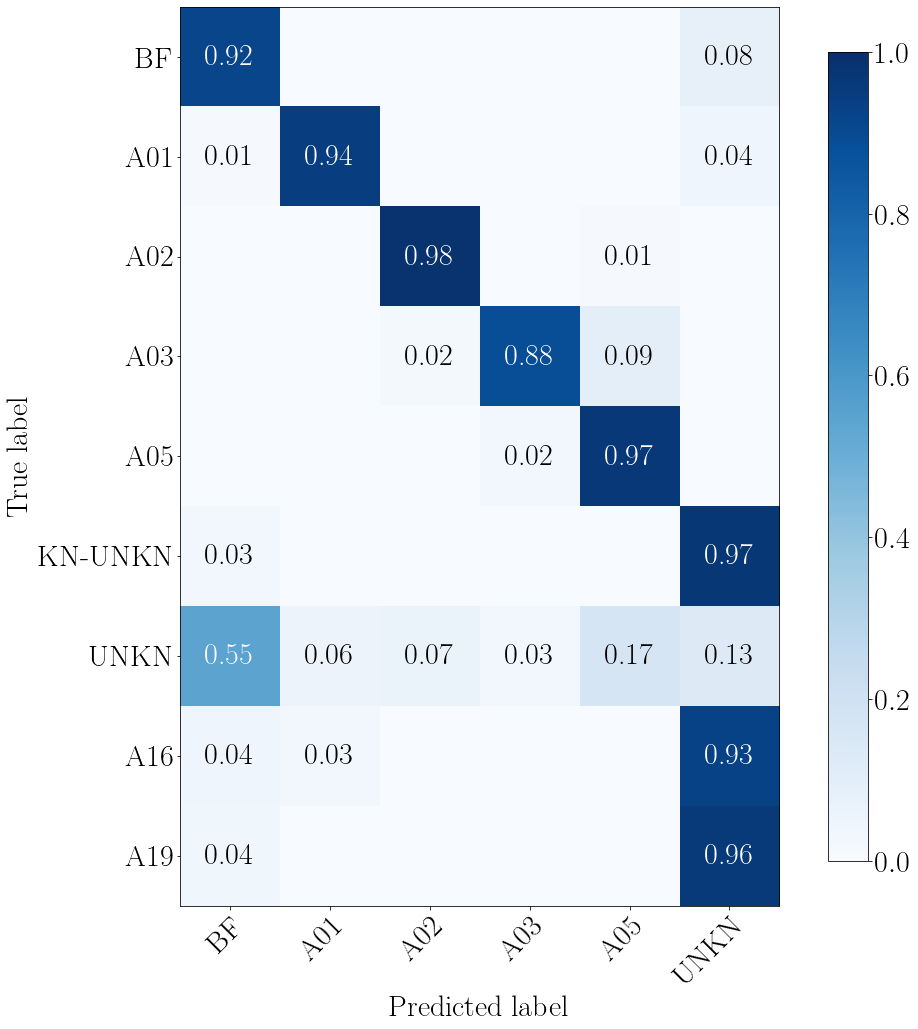

0.4541767627296317
svm
zscore
{'class__C': 1000, 'class__kernel': 'linear'}
Normalized confusion matrix


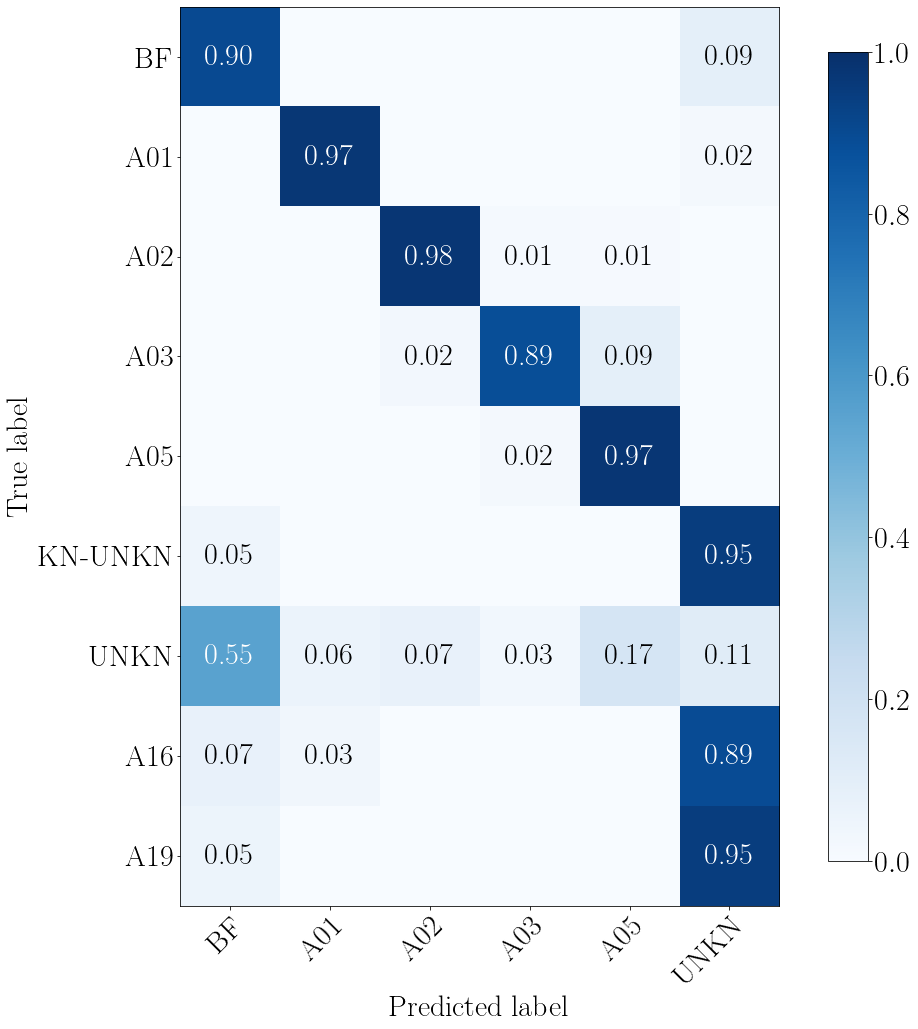

0.4484542283170937
svm
minmax
{'class__C': 1000, 'class__kernel': 'linear'}
Normalized confusion matrix


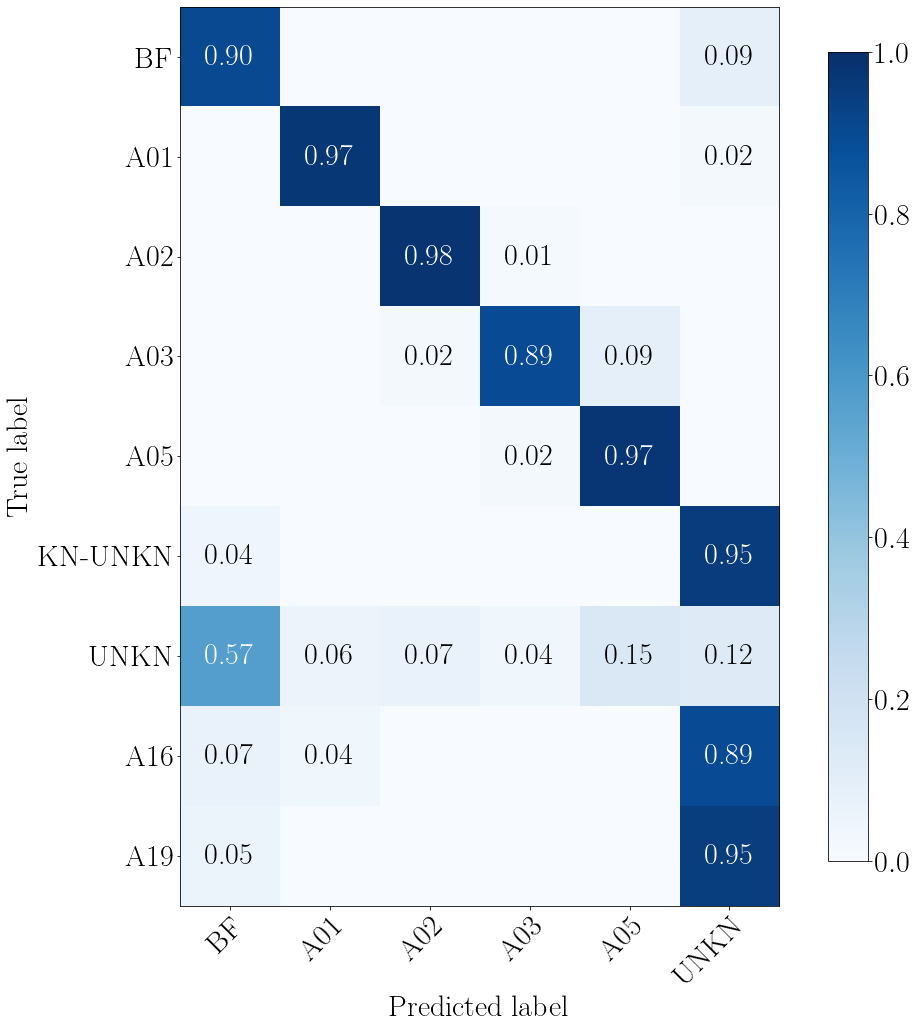

0.43152721211183864
svm
minmax
{'class__C': 1000, 'class__kernel': 'linear'}


In [18]:
for feat in selected_features_list:
    if feat == ['lpc']:
        partial = results_df[([a == feat for a in results_df['selected_features']])
                                ]
        best_row = partial[partial.tpr == partial.tpr.max()].squeeze()#.iloc[0,:]
        
        #plt.figure(figsize = (12,12))
        #plt.title("Feat {}".format(feat))
        
                  
        x_labels = np.array(['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'UNKN'])
        ku = np.array(best_row['known-unknown'])
        x_labels = np.concatenate([['BF'], np.setdiff1d(x_labels, ku)])

        y_labels =  ['KN-UNKN', 'UNKN', 'A16', 'A19']
        y_labels = np.concatenate([x_labels[:-1], y_labels])
        
        x_labels = list(x_labels)
        positions_a04 = [i for i, s in enumerate(x_labels) if 'A04' in s]
        if positions_a04:
            x_labels[positions_a04[0]] = 'A04 / A16'
        positions_a06 = [i for i, s in enumerate(x_labels) if 'A06' in s]
        if positions_a06:
            x_labels[positions_a06[0]] = 'A06 / A19'
        
        #sns.heatmap(best_row['cm'], annot=True, vmin=0, vmax=1, xticklabels=x_labels, yticklabels=y_labels)
        my_plot_confusion_matrix(best_row['cm'], normalize=True, x_labels=x_labels, y_labels=y_labels, start_sort=-1)
        plt.savefig('figures/open_set_feat_{}_NFFT_{}_hopsize_{}_unknown_{}'.format(
                feat, nfft, hop_size, best_row['known-unknown']), bbox_inches = 'tight')
        plt.show()
        print(best_row['tpr'])
        print(best_row['classifier'])
        print(best_row['normalization'])
        print(best_row['model_params'])            
    else:
        for fft_params in zip(nfft_list, hop_size_list):
            nfft = fft_params[0]
            hop_size = fft_params[1]
            partial = results_df[(results_df['nfft']==nfft) &
                                 ([a == feat for a in results_df['selected_features']])
                                ]
            
            best_row = partial[partial.tpr == partial.tpr.max()].squeeze()#.iloc[0,:]

            
            x_labels = np.array(['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'UNKN'])
            ku = np.array(best_row['known-unknown'])
            x_labels = np.concatenate([['BF'], np.setdiff1d(x_labels, ku)])

            y_labels =  ['KN-UNKN', 'UNKN', 'A16', 'A19']
            y_labels = np.concatenate([x_labels[:-1], y_labels])
            
            x_labels = list(x_labels)
            positions_a04 = [i for i, s in enumerate(x_labels) if 'A04' in s]
            if positions_a04:
                x_labels[positions_a04[0]] = 'A04/A16'
            positions_a06 = [i for i, s in enumerate(x_labels) if 'A06' in s]
            if positions_a06:
                x_labels[positions_a06[0]] = 'A06/A19'
            
            
            #sns.heatmap(best_row['cm'], annot=True, vmin=0, vmax=1, xticklabels=x_labels, yticklabels=y_labels)
            my_plot_confusion_matrix(best_row['cm'], normalize=True, x_labels=x_labels, y_labels=y_labels, start_sort=-1)
            plt.savefig('figures/open_set_feat_{}_NFFT_{}_hopsize_{}_unknown_{}'.format(
               feat, nfft, hop_size, best_row['known-unknown']), bbox_inches = 'tight')
            plt.show()
            
            print(best_row['tpr'])
            print(best_row['classifier'])
            print(best_row['normalization'])
            print(best_row['model_params'])


                